In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
import torch.nn as nn
import torch.optim as optim
import time

In [0]:
#transforms.RandomResizedCrop(input_dim_of_model)
#transforms.Normalize((x_mean,y_mean,z_mean), (x_sd,y_sd,z_sd))
transform=transforms.Compose([transforms.RandomResizedCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                              ])

In [8]:
trainset = torchvision.datasets.CIFAR10('./data', download=True, train=True, transform=transform)
valset = torchvision.datasets.CIFAR10('./data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
#sneak peak into the train data

#iterating into the data
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape) #shape of all 4 images
print(images[1].shape) #shape of one image
print(labels[1].item()) #label number

torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
6


In [0]:
#Pick suitable model according to your need
squeeze=models.SqueezeNet()

In [0]:
#transfer model to gpu
device=torch.device("cuda")
squeeze=squeeze.to(device)

In [0]:
#Exaluation function for checking accuracy
def evaluation_gpu(dataloader):
  #function to calculate the accuracy
    total, correct = 0, 0
    for data in dataloader:
      inputs, labels = data
      inputs,labels= inputs.to(device),labels.to(device)
      outputs = squeeze(inputs)
      #max_value, max_index = torch.max(tensor,axis)
      _, pred = torch.max(outputs.data, 1)
      #here total = total + batch_size
      total += labels.size(0)
      #here if pred and lables are equal then result will be 1 and we sum them up and fetch tensor value by item()
      correct += (pred == labels).sum().item()
      #print("Prediction from Model : ",pred)
      #print("labels : ",labels)
    return(100 * correct/total)

In [0]:
#for this lage models even 1 epoch will take a cosiderable time
def fit_gpu(trainloader,model,opt,loss_fn,epochs=5):
        time0=time.time()
        loss_arr = []
        loss_epoch_arr = []
        for epoch in range(epochs):
            running_loss=0
            for i, data in enumerate(trainloader, 0):

                inputs, labels = data
                inputs=inputs.to(device)
                labels=labels.to(device)

                #forward pass
                loss = loss_fn(squeeze(inputs), labels)

                #backward and optimize
                opt.zero_grad()
                loss.backward()
                opt.step()
                
                loss_arr.append(loss.item())
                running_loss += loss.item()
                
            loss_epoch_arr.append(loss.item())
            print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(trainloader)))    
            print('Epoch: %d/%d, Train acc: %0.2f' % (epoch, epochs, evaluation_gpu(trainloader)))
        print("Training Time(in minutes) =",(time.time()-time0)/60)       
        plt.plot(loss_epoch_arr)
        plt.show()

Epoch 0 - Training loss: 1.8503664772402226
Epoch: 0/5, Train acc: 34.44
Epoch 1 - Training loss: 1.7237937416087643
Epoch: 1/5, Train acc: 39.80
Epoch 2 - Training loss: 1.615552095366226
Epoch: 2/5, Train acc: 42.43
Epoch 3 - Training loss: 1.535421618649537
Epoch: 3/5, Train acc: 45.26
Epoch 4 - Training loss: 1.466506689195822
Epoch: 4/5, Train acc: 49.06
Training Time(in minutes) = 24.11207946538925


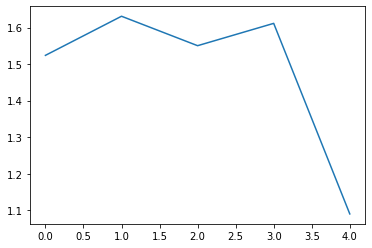

In [21]:
#Train our Pretrained Alexnet using GPU
loss_fn=nn.CrossEntropyLoss()
opt=optim.Adam(squeeze.parameters())
fit_gpu(trainloader,squeeze,opt,loss_fn)